# Busqueda del Centro de Masa de la Densidad de Fuentes de Corriente

Primero, vamos a intentarlo con un experimento que tenga una actividad notoria. Aquí cargamos un archivo que contiene los datos de un experimento con actividad epiléptica. La región CA aparece muy activa varias veces en las mediciones del potencial de campo local, LFP de ahora en adelante.

In [1]:
muacamuaca=open("DatosActividadEpilepticaSelectos.bin", "r")

IOStream(<file DatosActividadEpilepticaSelectos.bin>)

In [2]:
formaarray=(64,64,9101)

(64,64,9101)

In [3]:
Datos=read(muacamuaca, Float64, formaarray);

In [4]:
tmax=formaarray[3]


9101

In [5]:
close(muacamuaca)

No todos los datos son interesentas. La actividad se concentra en los siguientes cuadros.

In [6]:
#No todo es interesante. 
Datos=Datos[:,:,3500:8500]
tmax=size(Datos)[3]
formaarray=(64,64,tmax)

(64,64,5001)

Vamos a guardar la serie de tiempo de un electródo particular para comparar y hacer gráficas bonitas.

In [7]:
#Ejemplo a comparar
writedlm("ExampleDatosLargos-58-50.dat", reshape(Datos[58,50,:],tmax))

Aquí abajo definimos los filtros que matarán señales saturadas y pondran toda señal debajo de cierto umbral en cero.

In [8]:
function umbral(x)
    result=((abs(x)>500) ? 0 : x)
end;

function aplastar(x)
    result=((abs(x)<60) ? 0 : x)
end;

function UnNormGauss(x,sigma)
    return exp(-x*x/(2*sigma))
end

UnNormGauss (generic function with 1 method)

La umbralización de Otsu la vamos a aplicar sobre la desviación estándar en la señal de cada electródo. Para ello, primero quitamos los canales saturados y después calculamos este valor.

In [9]:
map!(umbral, Datos); #map! quiere decir map in situ
DesviacionPorElectrodo=zeros(64,64)
for j=1:64, k=1:64
    DesviacionPorElectrodo[j,k]=std(reshape(Datos[j,k,:],tmax));
end

Aqui viene una función que hace un suavizado Gaussiano sobre una serie de tiempo. Tengo la impresión de que esto no lo voy a usar.

In [11]:
function GaussSuavizar(Datos,Sigma)  
    #sigma esta medido en pixeles, es la desviacion estandar de nuestro kernel.
    #El medioancho de nuestra ventana seran 3 sigmas.
    #Bien, veamos como chingaos le ponemos "padding" a las convoluciones.
    medioancho=ceil(Sigma*3)
    colchon=ones(medioancho)
    result=zeros(Datos)
    datoscolchon=vcat(colchon*Datos[1], Datos, colchon*Datos[end])
    kernel=map(x->UnNormGauss(x,Sigma), [-medioancho:medioancho])
    kernel=kernel/(sum(kernel))
    #La convolucion asi normalizada preserva el valor RELATIVO entre los puntos de la funcion.
    #pero queremos ponerlo mas parecido a los voltajes que medimos, para preservar el rango de valores
    #experimentales y su criterio de potenciales de accion / ruido
    for t=medioancho+1:length(Datos)-medioancho
        result[t-medioancho]=sum(datoscolchon[t-medioancho:t+medioancho].*kernel)
    end
    a=maximum(abs(Datos))
    b=maximum(abs(result))
    result=result*a/b
    return result
end
    

GaussSuavizar (generic function with 1 method)

Esta función calcula la desviación estándar por ventanas temporales en cada canal. Franco uso esta información para separar sus canales de actividad neuronal de aquellas de ruido por medio de un procedimiento relativamente complejo. Esto se puede simplificar usando el criterio de Otsu para separar en cada ventana temporal y obtener un *"criterio de Otsu por ventanas"*.

In [12]:
function SigmaVentanas(Datos, ancho, paso)
    anchomedio=floor(ancho/2)
    tantos=convert(Int, floor((length(Datos)-ancho)/paso))
    result=zeros(tantos)
    for t=1:tantos
        result[t]=std(Datos[(t-1)*paso+1:(t-1)*paso+ancho])
    end
    return result  
end

SigmaVentanas (generic function with 1 method)

Aquí implementamos el método de Otsu, tal cual.

In [13]:
function OtsuMethod(Data)
    #Pa que esto funcione hay que mandar los datos ya sin NaNs u otras mugres   
    binsdefault=2*ceil(Int,sqrt(length(Data)))
    (rango, cuentas)=hist(Data,binsdefault)
    tantos=length(rango)
    valores
    omega1=0
    omega2=0
    mu1=0
    mu2=0
    sigmab=0
    sigmabtemp=0
    tbest=0
    varlim=0
    for t=1:tantos-1
        omega1=sum(cuentas[1:t])
        omega2=sum(cuentas[t+1:tantos-1])
        mu1=sum(cuentas[1:t].*rango[1:t])/omega1
        mu2=sum(cuentas[t+1:tantos-1].*rango[t+1:tantos-1])/omega2        
        sigmabtemp=omega1*omega2*((mu1-mu2)^2)
        if sigmabtemp>sigmab
            sigmab=sigmabtemp
            tbest=t
            varlim=rango[t]
        end
    end
    return (sigmab,tbest,varlim)
end

function OtsuUmbralizar(DatosMatriz)
    # aplanar datos
    DataFlatten=reshape(DatosMatriz, size(DatosMatriz)[1]*size(DatosMatriz)[2])
    mascara=zeros(DatosMatriz)
    umbral=OtsuMethod(DataFlatten)[3]
    mascara=map(x->(x>umbral)?1:0, DatosMatriz)
    return mascara
end


OtsuUmbralizar (generic function with 1 method)

Aplicamos la función DesviacionPorVentana a ventanas de 350 cuadros de duración, y avanzando 35 cuadros cada vez. Esto corresponde a aproximadamente ventanas de $49.8 \mu s$ y pasos de $ 4.9 \mu s$.

In [14]:
ancho=350
paso=35
cuantasventanas=convert(Int, floor((tmax-ancho)/paso))
DesviacionPorVentana=zeros((64,64,cuantasventanas))
for j=1:64, k=1:64
    chorizo=reshape(Datos[j,k,:],tmax)
    DesviacionPorVentana[j,k,:]=SigmaVentanas(chorizo, ancho, paso)
end

Aqui es donde mezclamos el criterio de Franco con la umbralización de Otsu. A cada una de las ventanas de desviaciones calculadas anteriormente en el arreglo DesviacionPorVentana le aplicamos el umbral de Otsu. Con eso formamos una máscara donde vamos sumando puntos cada vez que un canal está dentro de la umbralización de Otsu.

In [15]:
SumaVentanasOtsuUmbral=zeros(64,64)
for t=1:cuantasventanas
    SumaVentanasOtsuUmbral+=OtsuUmbralizar(DesviacionPorVentana[:,:,t])
end

In [ ]:
using PyPlot

Usemos PyPlot para hacer un par de imagenes bonitas para poder seguir más fácilmente la discución. Por ejemplo, aquí pongamos una  imagén de la densida de esta máscara sumada de Otsu por ventanas.

In [1]:
figure(figsize=(3.5,3.5))
imagen=imshow(SumaVentanasOtsuUmbral, cmap="gist_heat", origin="lower")
colorbar(imagen)
#origin lower sigue la convención gnuplot. Origen abajo izquierda. La otra sigue la convención matrix (default).

LoadError: figure not defined
while loading In[1], in expression starting on line 1

Como podemos ver, la umbralización de Otsu se acumula más sobre el Cuerno de Amón. La pequeña zona de actividad cerca de (35,30) puede ser parte del Giro Dentado. No se.

In [18]:
writedlm("MascaraOtsuRica01.dat", SumaVentanasOtsuUmbral)

Ahora tenemos que decidir hasta que punto un registro contiene actividad neuronal. Aquí hemos llevado a cabo la superposición de aprox 120 umbrales de Otsu, realmente. Asi que aquellos que pasen más de un cuarto de las veces serán considerados canales con actividad neuronal.

In [19]:
MascaraOtsu=zeros(64,64);
MascaraOtsu=map(x->(x>35)?1:0, SumaVentanasOtsuUmbral);

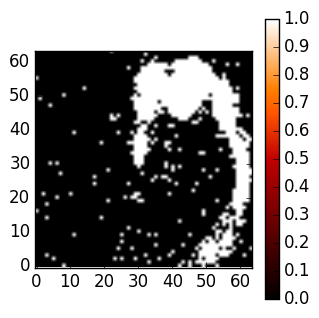

PyObject <matplotlib.colorbar.Colorbar object at 0x7f4a925d6cf8>

In [20]:
figure(figsize=(3.5,3.5))
imagen=imshow(MascaraOtsu, cmap="gist_heat", origin="lower")
colorbar(imagen)
#origin lower sigue la convención gnuplot. Origen abajo izquierda. La otra sigue la convención matrix (default).

La máscara así obtenida tiene huecos y puntos sueltos. Para normalizarla un poco y tratar de que sea un objeto de un componente conexo, le aplicamos la función mostrada abajo. Esta función quita los canales que se encuentren sin vecinos y añade aquellos que se encuentren rodeados por al menos otros dos puntos.

In [21]:
function ParchaMascara01(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    (alto,ancho)=size(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    
    colchonvertical=zeros(1,ancho)
    colchonhorizontal=zeros(alto+2)
    
    temp=vcat(colchonvertical, temp, colchonvertical)
    temp=hcat(colchonhorizontal, temp, colchonhorizontal)
    
    
    for j=2:alto+1, k=2:ancho+1
        aux=temp[j-1:j+1,k-1:k+1]
        test=sum(aux)
        if(temp[j,k]<2.0 && test<2.1)
            result[j-1,k-1]=0
        #    println(j,k)
        elseif(temp[j,k]<1.1 && test>2.0)
            result[j-1,k-1]=1
        else
            result[j-1,k-1]=temp[j,k]
        end
    end   

    return result
    
end


ParchaMascara01 (generic function with 1 method)

In [22]:
MascaraOtsu=ParchaMascara01(MascaraOtsu);

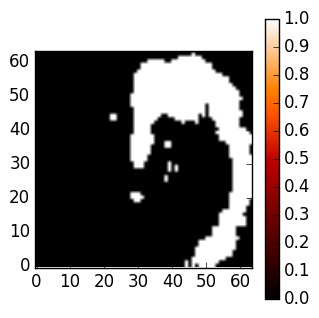

PyObject <matplotlib.colorbar.Colorbar object at 0x7f4a65c3ebe0>

In [23]:
figure(figsize=(3.5,3.5))
imagen=imshow(MascaraOtsu, cmap="gist_heat", origin="lower")
colorbar(imagen)
#origin lower sigue la convención gnuplot. Origen abajo izquierda. La otra sigue la convención matrix (default).

Creo que está bien. Tal vez podríamos quitar los componentes fuera del cuerpo principal más tarde.
Seleccionamos los canales que están dentro de la Máscara.

In [24]:
DatosLimpios=zeros(64,64,tmax)
for t=1:tmax
    DatosLimpios[:,:,t]=Datos[:,:,t].*MascaraOtsu
end

Verificamos que este canal en particular sigue dentro de la máscara, para ejemplos.

In [25]:
MascaraOtsu[58,50]

1

In [26]:
writedlm("MascaraOtsu01.dat", MascaraOtsu)

Ahora sí, ya que el ruido ha servido su propósito, podemos anularlo. 

In [27]:
map!(aplastar, DatosLimpios);

In [29]:
#Tal ves esto no es necesario.
Chumbaganga=zeros(DatosLimpios);
for j=1:64, k=1:64
    if(MascaraOtsu[j,k]==1)
        Chumbaganga[j,k,:]=GaussSuavizar(reshape(DatosLimpios[j,k,:],tmax),7)
    end    
end

In [30]:
writedlm("ExampleDatosLargosUmbrales-58-50.dat", reshape(DatosLimpios[58,50,:],tmax))
writedlm("ExampleDatosLargosSuaves-58-50.dat", reshape(Chumbaganga[58,50,:],tmax))

In [31]:
GaussianKernel=readdlm("GaussianMatrix.dat");
function GaussianSmooth(Datos)
    tamanodatos=size(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    for j=1:3
        temp=vcat(temp[1,:], temp, temp[end,:])
    end
    for j=1:3
        temp=hcat(temp[:,1], temp, temp[:,1])
    end
    
    for j=4:tamanodatos[1]+3, k=4:tamanodatos[2]+3
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-3:j+3,k-3:k+3]
        result[j-3,k-3]=sum(GaussianKernel.*aux)
    end
    #piensa como normalizar
    #result=result*maximum(abs(Datos))/maximum(abs(result))
    return result
end

GaussianSmooth (generic function with 1 method)

In [32]:
Sumbaganga=zeros(formaarray)
for t=1:tmax
    Sumbaganga[:,:,t]=GaussianSmooth(DatosLimpios[:,:,t])
end

In [33]:
extrema(Sumbaganga)

(-407.482117565918,418.1369040838623)

In [34]:
Datos=0

0

In [35]:
gc()

In [41]:
# a escribir, pa variar
for t=1:tmax
#    aux=map(x-> isnan(x)?0:x, Chumbaganga[:,:,t])
    zacatlan="./GarbageCollector/GaussianFilteredSpaceTime-$t.dat"
    writedlm(zacatlan, Sumbaganga[:,:,t])
end


In [36]:
LaplacianKernel=zeros(3,3);
#checa que Julia va ordenando los datos renglon por renglon, no columna por columna
LaplacianKernel=[[0.5 1. 0.5], [1. -6. 1], [0.5 1. 0.5]];

function DiscreteLaplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float64,(3,3))
    result=zeros(Datos)
    for j=2:largo, k=2:ancho
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j-1,k-1]=sum(LaplacianKernel.*aux)
    end
    return result
end

DiscreteLaplacian (generic function with 1 method)

In [37]:
Laplaganga=zeros(formaarray)
for t=1:tmax
    Laplaganga[:,:,t]=DiscreteLaplacian(Sumbaganga[:,:,t])
end

In [44]:
for t=1:tmax
#    aux=map(x-> isnan(x)?0:x, Chumbaganga[:,:,t])
    zacatlan="GarbageCollector/LaplacianFilteredSpaceTime-$t.dat"
    writedlm(zacatlan, Laplaganga[:,:,t])
end


Hagamos un par de comparaciones. Como se ven ANTES y DESPUES del filtro Laplaciano.

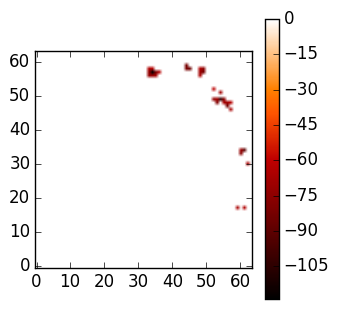

PyObject <matplotlib.colorbar.Colorbar object at 0x7f4a522819b0>

In [38]:
figure(figsize=(3.5,3.5))
imagen=imshow(DatosLimpios[:,:,1999], cmap="gist_heat", origin="lower")
#otraimagen=imshow(Laplaganga[:,:,1999], cmap="gist_heat", origin="lower")
colorbar(imagen)
#origin lower sigue la convención gnuplot. Origen abajo izquierda. La otra sigue la convención matrix (default).

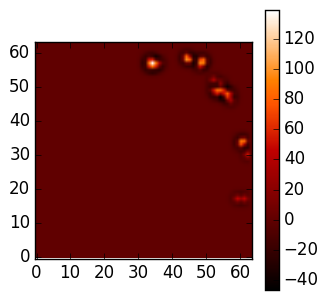

PyObject <matplotlib.colorbar.Colorbar object at 0x7f4a521d33c8>

In [39]:
figure(figsize=(3.5,3.5))
#imagen=imshow(DatosLimpios[:,:,1999], cmap="gist_heat", origin="lower")
otraimagen=imshow(Laplaganga[:,:,1999], cmap="gist_heat", origin="lower")
colorbar(otraimagen)
#origin lower sigue la convención gnuplot. Origen abajo izquierda. La otra sigue la convención matrix (default).

Otra versión del Laplaciano, para esto necesitaremos usar Grid e interpolaremos. Quien sabe si funcione.

In [47]:
using Grid

In [48]:
function PseudoContiniusLaplacian(Data)
    LaplacianKernel=[[0.5 1. 0.5], [1. -6. 1], [0.5 1. 0.5]];
    xx=1:64
    yy=1:64
    zz=CoordInterpGrid((xx, yy), Data, BCnearest, InterpQuadratic)
    result=zeros(Data)
    epsilon=0.1
    aux=zeros(3,3)
    #sopas=zz[0.9,0.9]
    for j=1:64, k=1:64
        aux=[[zz[j-epsilon,k-epsilon] zz[j-epsilon,k] zz[j-epsilon,k+epsilon]],
            [zz[j,k-epsilon] zz[j,k] zz[j,k+epsilon]],
            [zz[j+epsilon,k-epsilon] zz[j+epsilon,k] zz[j+epsilon,k+epsilon]]]
        result[j,k]=sum(aux.*LaplacianKernel)
    end
    return result
end

PseudoContiniusLaplacian (generic function with 1 method)

In [49]:
PseudoLapla=PseudoContiniusLaplacian(Sumbaganga[:,:,1999]);

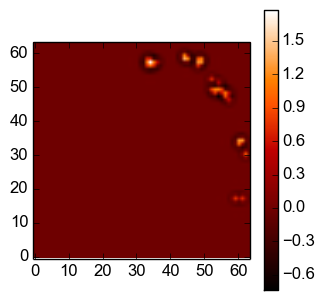

PyObject <matplotlib.colorbar.Colorbar instance at 0x7ff08c104518>

In [50]:
figure(figsize=(3.5,3.5))
#imagen=imshow(DatosLimpios[:,:,1999], cmap="gist_heat", origin="lower")
otraimagen=imshow(PseudoLapla, cmap="gist_heat", origin="lower")
colorbar(otraimagen)

In [51]:
ContLapla=zeros(Sumbaganga)
for t=1:tmax
    ContLapla[:,:,t]=PseudoContiniusLaplacian(DatosLimpios[:,:,t])
end


In [56]:
#Quita la basura numerica porfa
map!(x->abs(x)<0.001? 0:x, Laplaganga); 

In [54]:
for t=1:tmax
#    aux=map(x-> isnan(x)?0:x, Chumbaganga[:,:,t])
    zacatlan="GarbageCollector/ContinousLapla-$t.dat"
    writedlm(zacatlan, ContLapla[:,:,t])
end


In [42]:
function vecindad8(punto::Array)
    j=punto[1]
    k=punto[2]
    result=Set{Array{Int64,1}}()
    push!(result, [j-1,k-1])
    push!(result, [j-1,k])
    push!(result, [j-1,k+1])
    push!(result, [j,k-1])
    push!(result, [j,k+1])
    push!(result, [j+1,k-1])
    push!(result, [j+1,k])
    push!(result, [j+1,k+1])
    return result
end
    

vecindad8 (generic function with 1 method)

In [44]:
ActividadNegativa=Array{Int16}[]
ActividadPositiva=Array{Int16}[]
SpikeCountPositivo=zeros(64,64);
SpikeCountNegativo=zeros(64,64);
for j=1:64, k=1:64
    if(Laplaganga[j,k,1999]<-0.0)      
        push!(ActividadNegativa, [j, k])
        SpikeCountNegativo[j,k]+=1
    elseif(Laplaganga[j,k,1999]>0.0) 
        push!(ActividadPositiva, [j, k])
        SpikeCountPositivo[j,k]+=1
    end             
end


In [45]:
writedlm("SpikeCountNegativo.dat", SpikeCountNegativo)
writedlm("SpikeCountPositivo.dat", SpikeCountPositivo)

In [46]:
#Simple pass method
lista=copy(ActividadPositiva)
curlab=0
componentes=Set{Any}()
while(length(lista)!=0)
    x=pop!(lista) #arranca el ULTIMO elemento de la lista
    listaprofundeza=Array{Int64}[]
    componentecurlab=Array{Int64}[]
    push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
    push!(componentecurlab, x)    
    profundidad=0
    while ((length(listaprofundeza)!=0) && profundidad<100)
        y=pop!(listaprofundeza)
        for v in vecindad8(y)
                if in(v, lista)
             #   println(indexin({v},lista), v)
                deleteat!(lista, indexin({v}, lista))
            #    println(v, "si estaba en la lista")
             #   println(lista)
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                else
                    #println(v, "no estaba en la lista")
                end
            end
    end
    # println("Para ", x, "la profundidad fue ", profundidad)
    curlab+=1
    push!(componentes, componentecurlab)
end
curlab

7

In [49]:
centrosdemasa=[[0 0 0];]
for p in componentes
    masa=0.00
    x=0.00
    y=0.00
    for q in p
        j=q[1]
        k=q[2]
        masalocal=Laplaganga[j,k,1999]
        masa+=masalocal
        x+=k*masalocal
        y+=j*masalocal
    end
    x/=masa
    y/=masa
    A=[x y masa]
    centrosdemasa=vcat(centrosdemasa, A)
end
centrosdemasa=centrosdemasa[2:end,:]

7x3 Array{Float64,2}:
 45.3286  59.3534  306.404 
 60.9775  18.0     170.781 
 62.8596  30.9519   87.3189
 49.4622  58.211   401.54  
 35.042   57.856   665.437 
 55.4277  49.566   778.289 
 61.4142  34.6849  300.231 

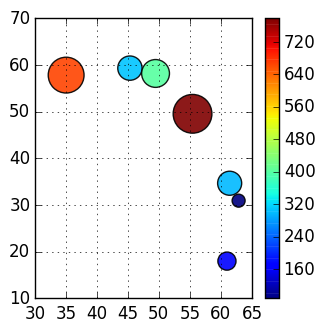

In [57]:
figure(figsize=(3.5,3.5))
imagen=scatter(centrosdemasa[:,1], centrosdemasa[:,2], c=centrosdemasa[:,3], s=abs(1*centrosdemasa[:,3]), alpha=0.9)
colorbar(imagen)
grid()

In [55]:
writedlm("quiensabequepedo.dat", centrosdemasa)

Eso fue la prueba con un sólo cuadro de actividad. Veamos ahora si podemos hacer todo de un jalón.

In [58]:
@time for t=1500:2000
    #iniciar variables vacias
    ActividadNegativa=Array{Int16}[]
    ActividadPositiva=Array{Int16}[]
    SpikeCountPositivo=zeros(64,64)
    SpikeCountNegativo=zeros(64,64)
    
    for j=1:64, k=1:64
        if(Laplaganga[j,k,t]<-0.0)      
            push!(ActividadNegativa, [j, k])
            SpikeCountNegativo[j,k]+=1
        elseif(Laplaganga[j,k,t]>0.0) 
            push!(ActividadPositiva, [j, k])
            SpikeCountPositivo[j,k]+=1
        end             
    end

    #Simple pass method
    lista=copy(ActividadNegativa)
    componentes=Set{Any}()
    while(length(lista)!=0)
        x=pop!(lista) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<100)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, lista)
             #   
                    deleteat!(lista, indexin({v}, lista))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        curlab+=1
        push!(componentes, componentecurlab)
    end


    centrosdemasa=[[0 0 0];]
    for p in componentes
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
            masalocal=Laplaganga[j,k,t]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasa=vcat(centrosdemasa, A)
    end
    centrosdemasa=centrosdemasa[2:end,:]
    zacatlan="GarbageCollector/CMNegLapla-$t.dat"
    writedlm(zacatlan, centrosdemasa)
end

elapsed time: 63.332942468 seconds (13137996696 bytes allocated, 14.64% gc time)
